In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches

In [2]:
# Open dataset for DIC
dir = '/home/jovyan/SOARS_2021/Data/Obs/BGC/'
fn_dissic = 'OceanSODA-ETHZ_1985-2019_v2020b.nc'

data_omga = xr.open_dataset(dir+fn_dissic)
data_omga

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360, time: 408)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time            (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2018-12-01
Data variables: (12/13)
    CO3             (time, lat, lon) float64 ...
    DIC             (time, lat, lon) float64 ...
    HCO3            (time, lat, lon) float64 ...
    TA              (time, lat, lon) float64 ...
    TAstd           (time, lat, lon) float64 ...
    omegaAR         (time, lat, lon) float64 ...
    ...              ...
    pCO2            (time, lat, lon) float64 ...
    pCO2std         (time, lat, lon) float64 ...
    pH              (time, lat, lon) float64 ...
    revelle_factor  (time, lat, lon) float64 ...
    salinity        (time, lat, lon) float64 ...
    temperature     (time, lat, lon) float64 ...
Attributes:
    contact:      gregorl@ethz.ch
    author:       Luke Gregor
    institution:  ETH Zuerich
    date:         2020-11-01
    changelog:    v2020b: missing data for 1985-01 and 2018-12 now filled
    reference:    Gregor, L. and Gruber, N.: OceanSODA-ETHZ: A global gridded...
    source:       https://doi.org/10.25921/m5wx-ja34
    description:  The marine carbonate system solved using pCO2 and TA estima...

In [3]:
omga = data_omga['omegaAR']

In [4]:
# select dimensions!
omg_a = omga.sel(lat=slice(0,70), lon=slice(-170,-90))

In [5]:
# remove long term trend for each grid cell
var = stats.rm_poly(omg_a,order=2,dim='time',nan_policy='drop')
#var = omg_a

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1361: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [6]:
# 1982-2010 period
base = var.sel(time=slice('1985-01','2010-12'))
tos_base = base

In [7]:
# Blob period
blob = var.sel(time=slice('2013-07','2016-06'))
tos_blob = blob

In [8]:
# Difference between the two periods
blob_anom = blob.groupby('time.month') - base.groupby('time.month').mean()

In [9]:
# Resample to two month resolution
cesm = blob_anom.resample(time='2M').mean()
cesm

<xarray.DataArray (lat: 70, lon: 80, time: 19)>
array([[[-0.05395404, -0.03185595, -0.01557526, ...,  0.32074407,
          0.06842559,  0.03643536],
        [-0.03141877, -0.0254828 , -0.01154346, ...,  0.32031482,
          0.06895596,  0.03681103],
        [-0.02021453, -0.03078797, -0.01773091, ...,  0.33685975,
          0.05837625,  0.01638804],
        ...,
        [-0.06638944, -0.02335966, -0.0455781 , ...,  0.03448753,
         -0.06981047, -0.10205214],
        [-0.09210914, -0.0769472 , -0.08122918, ..., -0.01025038,
         -0.01016561, -0.01412379],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.06058631, -0.04260338, -0.03040089, ...,  0.25600086,
          0.07359429,  0.04636766],
        [-0.04462949, -0.0265378 , -0.03359329, ...,  0.25599218,
          0.06524534,  0.04667728],
        [-0.01567222, -0.02849983, -0.03116102, ...,  0.2643639 ,
          0.06130126,  0.05028891],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,  0.0142343 , -0.0607439 , ...,         nan,
                 nan,         nan],
        [        nan,  0.02116953, -0.03698226, ...,         nan,
                 nan,         nan],
        [        nan, -0.04249545, -0.03910763, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-31 2013-09-30 ... 2016-07-31
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 -169.5 -168.5 -167.5 -166.5 ... -92.5 -91.5 -90.5

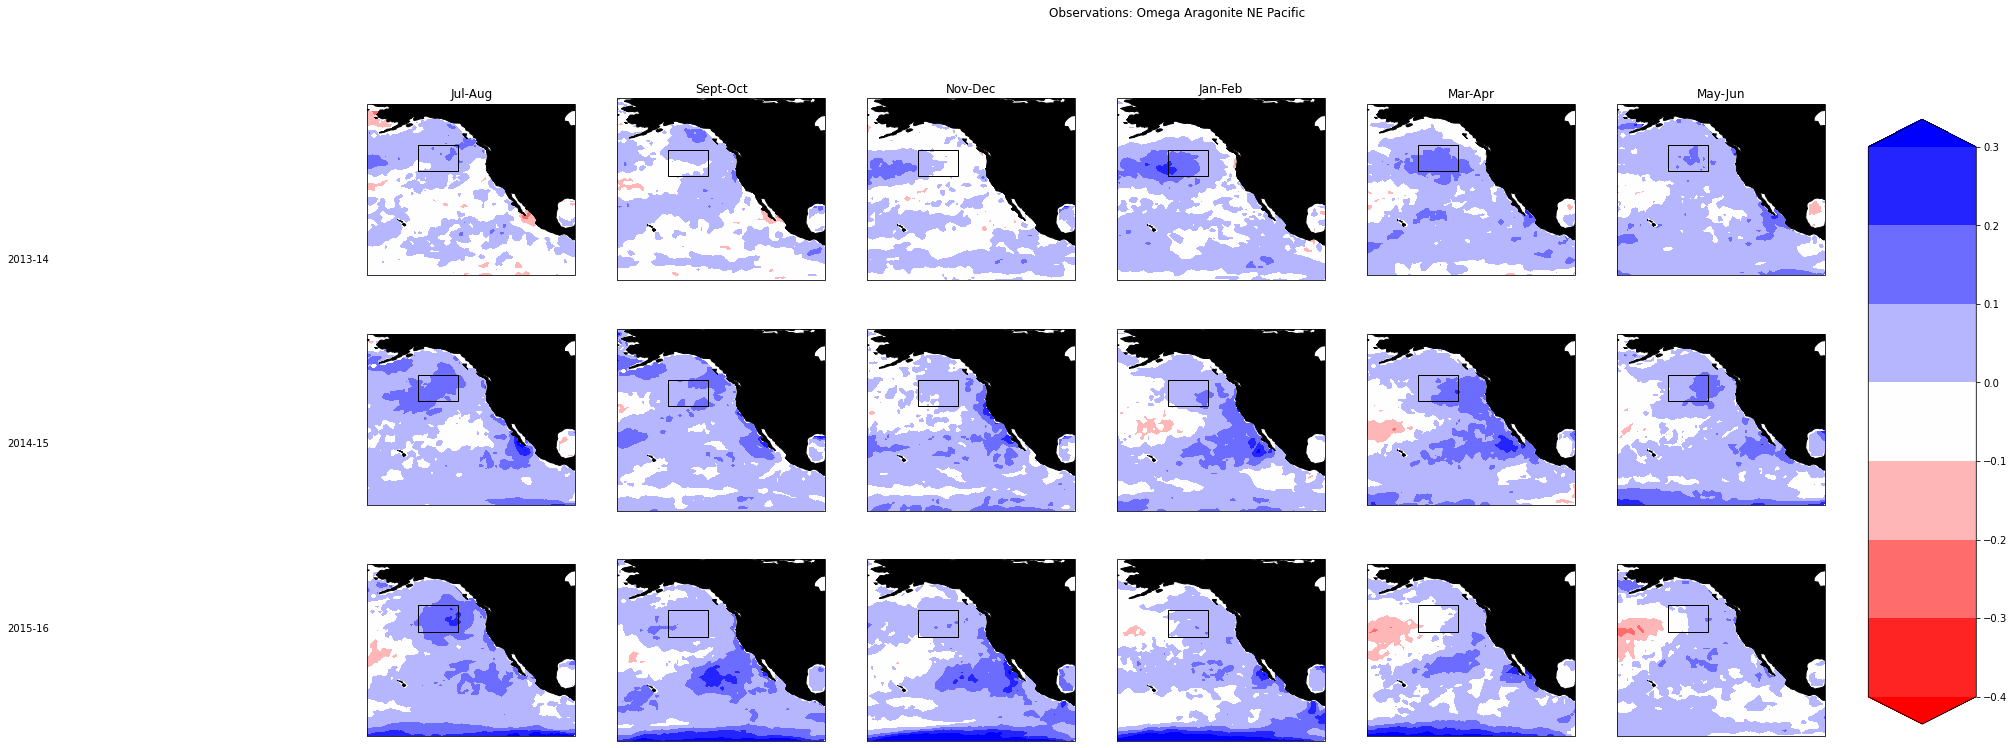

In [10]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step,cmap):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(30,12),
                          subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))) 
    axs = axs.flatten()
    for i in range(0,18):
        im = axs[i].contourf(cesm.lon, cesm.lat, cesm.isel(time=i),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap,
                         levels=np.arange(lower_bound, upper_bound, step),
                         extend='both')
        axs[i].add_feature(cfeature.LAND, color='k')
        axs[i].add_patch(mpatches.Rectangle(xy=[210, 40], width=15, height=10,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree())
                 )
    plt.suptitle("Observations: " + description + " " + variable + " " + depth) # + " (de-trended)")
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-600,180,'2013-14')
    plt.text(-600,110,'2014-15')
    plt.text(-600,40,'2015-16')
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax,fraction=0.046,pad=0.04)
    
panels(omg_a,'Omega Aragonite','NE','Pacific',-0.4,0.4, 0.1,'bwr_r')